# Prediction: Tension Models
---
> Graph neural network model for vertex dynamics and tension prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [3]:
from collections import OrderedDict
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies, HaraAblation
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, RecoilAsTension
from simgnn.transforms import AppendReversedEdges, AppendEdgeNorm, AppendDiff_x, Reshape_x
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


### Datasets

---
- **Normalisation param-s**

In [5]:
# Data normalisation param-s : sim="default" for simulation data
# Average edge lengths
l_0 = {'sim':1.0, 'single_distr_sims':1.1, 'unimodal_wbasetens_sims':0.91, 'hara':26.32, 'abln':50.13}

# Stat-s for raw tension/recoil values
t_av = {'sim':0.6, 'single_distr_sims': 0.58, 'unimodal_wbasetens_sims': 1.6, 'abln': 0.83}
t_sd = {'sim':0.63, 'single_distr_sims': 0.64, 'unimodal_wbasetens_sims':0.73 , 'abln': 0.65}

**Input features and normalisation param-s (transforms)**

In [6]:
# Input features
window_size = 5
print(f'> Set features window size to --> {window_size}')

# Simulation dataset
Tnrm = {k: [Pos2Vec(scale=10*l_0[k]) , ScaleVelocity(0.5*l_0[k]), ScaleTension(t_sd[k], shift=t_av[k])]
        for k in ['sim', 'single_distr_sims', 'unimodal_wbasetens_sims']}

# Hara ablation dataset
Tnrm['abln'] = [Pos2Vec(scale=10*l_0['abln']), ScaleVelocity(0.5*l_0['abln']),
                RecoilAsTension(), ScaleTension(t_sd['abln'], shift=t_av['abln'])]

# Hara movie dataset
Tnrm['hara'] = [Pos2Vec(scale=10*l_0['hara']) , ScaleVelocity(0.5*l_0['hara'])]

# Node and Edge Feature Transforms
for k in Tnrm:
    # to undirected graph: add e_ji for all e_ij
    Tnrm[k].append(AppendReversedEdges())
    
    # Add edge features
    Tnrm[k].append(AppendDiff_x())
    Tnrm[k].append(AppendEdgeNorm())
    
    # flatten  node features
    Tnrm[k].append(Reshape_x((-1,window_size*2)))
    
    Tnrm[k] = T.Compose(Tnrm[k])

> Set features window size to --> 5


**Load datasets**

- if a new `w` parameter is set, delete the older *processed* dataset files

In [7]:
!rm -dr simgnn_data/single_distr_sims/train/processed
!rm -dr simgnn_data/single_distr_sims/val/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/train/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed

!rm -dr simgnn_data/hara_movies/processed/
!rm -dr simgnn_data/hara_ablation/processed/

# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/

In [8]:
hara_abln = HaraAblation('simgnn_data/hara_ablation/', window_size=window_size, transform=Tnrm['abln'], smoothing=True, sma_lag_time=3)
hara = HaraMovies('simgnn_data/hara_movies/',window_size=window_size, transform=Tnrm['hara'], smoothing=True, sma_lag_time=4)

# Hara movie datasets
# seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg001_raw = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorm_hara)
# seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)

# Simulation datasets
# rand base contractility
sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size,
#                       transform=Tnrm['sim']
                      transform=Tnrm['unimodal_wbasetens_sims']
                     )
sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size,
#                           transform=Tnrm['sim']
                          transform=Tnrm['unimodal_wbasetens_sims']
                         )

# w/o base contractility
sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size,
#                       transform=Tnrm['sim']
                      transform=Tnrm['single_distr_sims']
                     )
sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size,
#                           transform=Tnrm['sim']
                          transform=Tnrm['single_distr_sims']
                         )


datasets_dict = {'train': sim1,
                 'val': sim1_val,
                 'val2': sim2_val,
                 'hara' : hara,
                 'abln': hara_abln}
dataset_legend={'train': 'Train(sim1)',
                'val': 'Val(sim1)',
                'val2': 'Val(sim2)',
                'hara': 'Hara',
                'abln': 'Recoil'}

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [9]:
# k = 'val2'
# t = 15
# print('{}\n{} : {}\nsize:{}\n\nFrame {}:\n{}'.format(dataset_legend[k],k,datasets_dict[k],len(datasets_dict[k]),t,datasets_dict[k][0]))
# plt.figure(figsize=[2.5,2.5])
# nx.draw(to_networkx(datasets_dict[k][t]),pos=dict(enumerate(datasets_dict[k][t].pos.numpy())), node_size=10)

## Load Trained Model

In [10]:
from simgnn.train import train_model, load_log, plot_losses

# from simgnn.nn import mlp, IndependentBlock, MessageBlock, dims_to_dict, Encode_Process_Decode
from simgnn.models import construct_simple_gnn, GraphEncoder, GraphDecoder, GraphProcessor

In [11]:
import simgnn.hardcoded as hcmodels # hardcoded models for testing and experimentation

In [12]:
# # # # # Load Saved Model:
# model_dir = './simgnn_data/saved_models/tension_test'
# model_fname = '07122021_202217_model_04122021_bs2w5'
# train_log = load_log(path.join(model_dir,
#                                '07122021_202217_model_04122021_bs2w5'+'_train_log.pkl'))

# net = hcmodels.get_model_04122021().to(device)
# net.load_state_dict(torch.load(path.join(model_dir, '07122021_202217_model_04122021_bs2w5'+'_net.pkl'),
#                                map_location=device))

In [13]:
model_dir = './simgnn_data/saved_models/'
model_fname = '17122021_091435_YesNrmYesDiffX_bs2w5'
train_log = load_log(path.join(model_dir, model_fname + '_train_log.pkl'))

net = hcmodels.get_model_YesNrmYesDiffX().to(device)
net.load_state_dict(torch.load(path.join(model_dir, model_fname + '_net.pkl'),
                               map_location=device))

<All keys matched successfully>

## Plot Predictions

In [14]:
from simgnn.train import predict, predict_batch, plot_velocity_predictions, plot_tension_prediction
from simgnn.train import predict_abln_tension, predict_dataset_tension, predict_dataset

from scipy.stats import pearsonr

- train_loss_tot =0.20582083579142987;
- train_loss_y =0.004660113439459741;
- train_loss_T =0.20116072235197013;
- val_loss_tot =0.5489792765522226;
- val_loss_y =0.004540479086525006;
- val_loss_T =0.5444387974656976;
- val2_loss_tot =0.6147441168223301;
- val2_loss_y =0.004102828801434018;
- val2_loss_T =0.6106412880208961;
- hara_loss_tot =0.0013380403406368644;
- hara_loss_y =0.0013380403406368644;
- hara_loss_T =0.0;



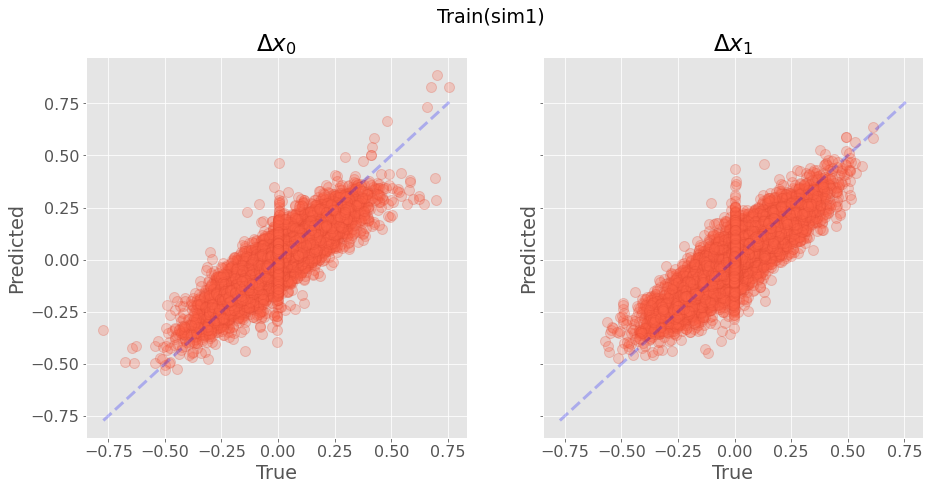

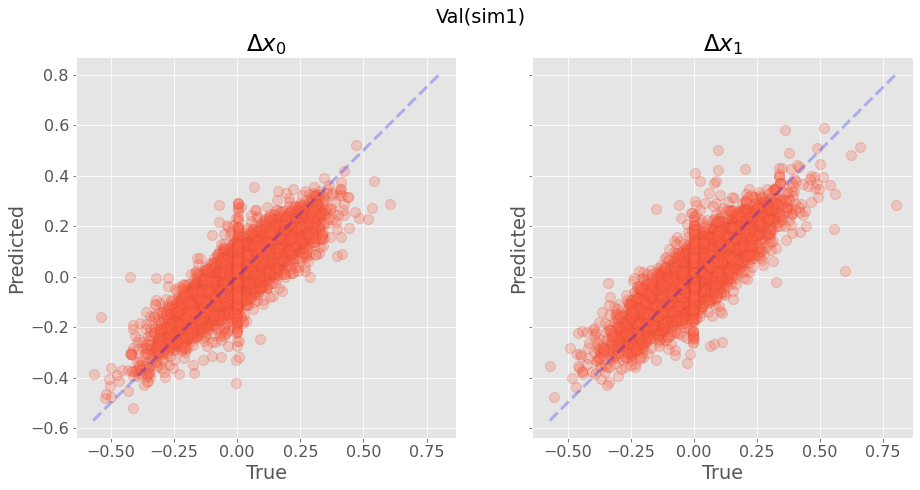

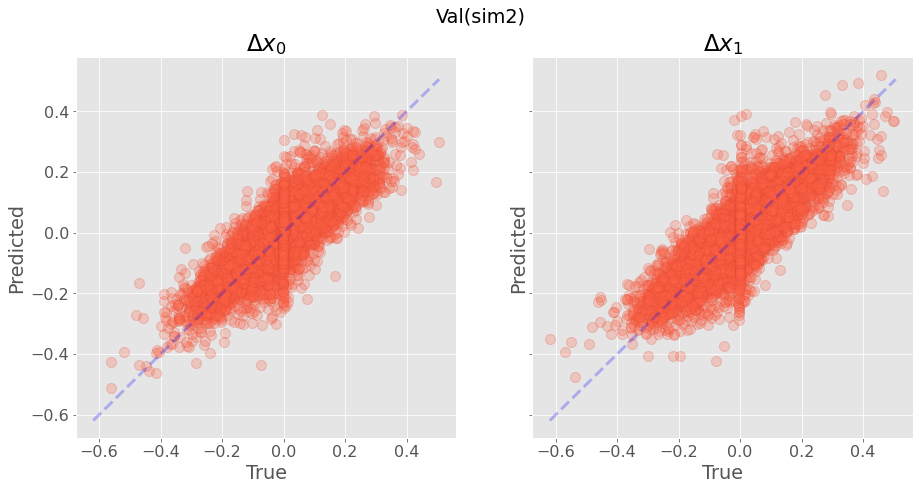

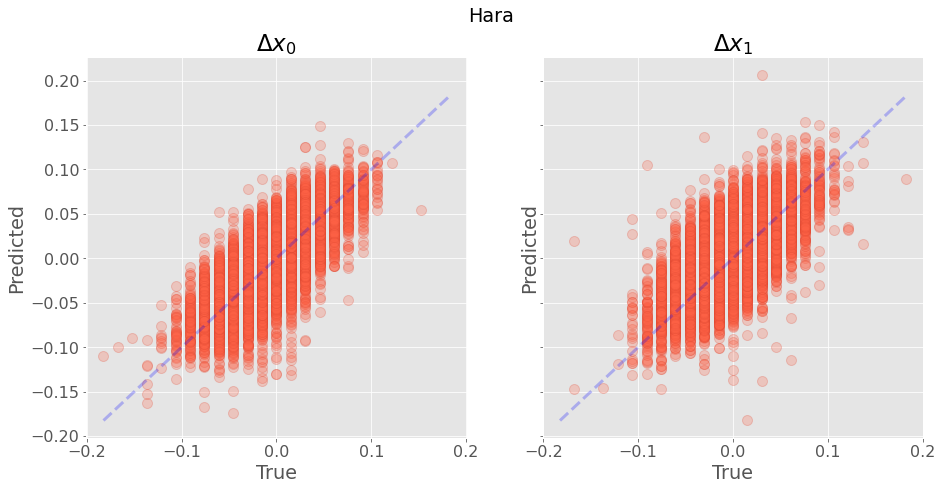

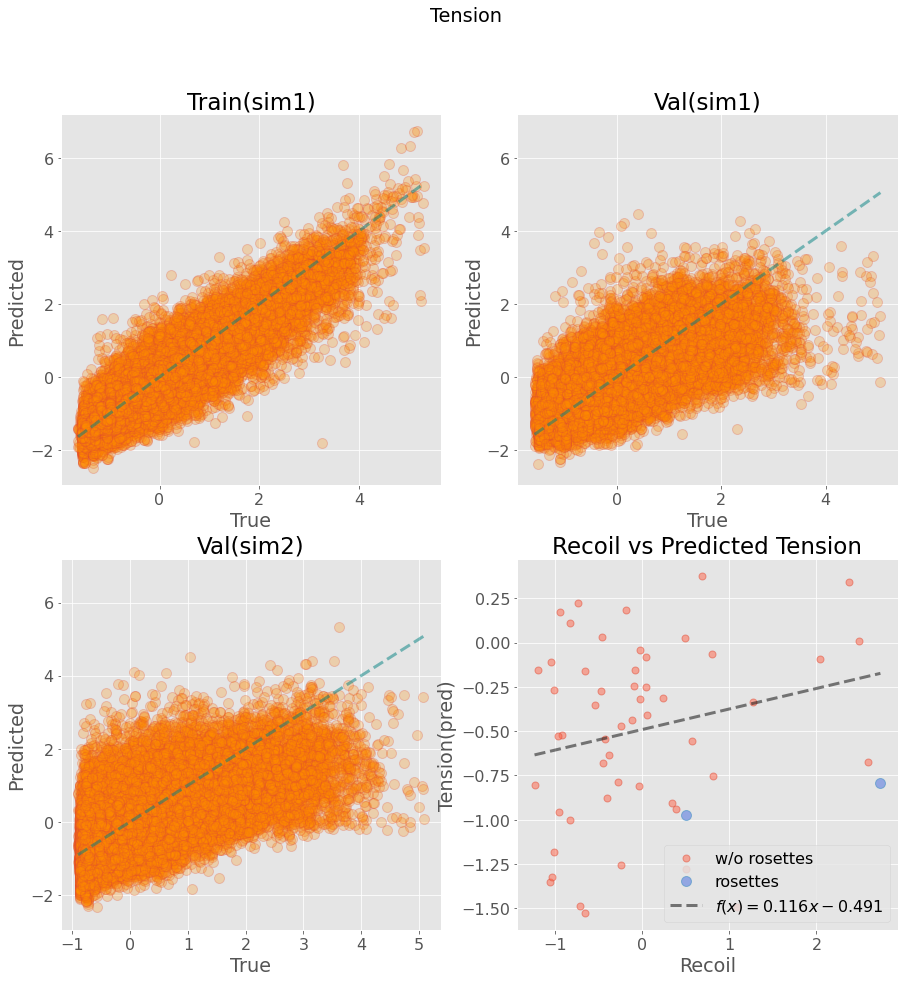

- - - - - - - - - - -
NO___rosettes : R,p=(0.2144717372096258, 0.12680827889528928)
WITH_rosettes : R,p=(0.15607157390111825, 0.2597534692990583)
- - - - - - - - - - -


In [15]:
# compute predictions and plot them
# vel-y, tens, pres
bs = 2

pred_out, tgt_out, sample_losses = predict_batch(net,
                                                 {
                                                  'train' : DataLoader(datasets_dict['train'], batch_size=bs),
                                                  'val':    DataLoader(datasets_dict['val'],  batch_size=bs),
                                                  'val2':   DataLoader(datasets_dict['val2'], batch_size=bs),
                                                  'hara':   DataLoader(datasets_dict['hara'], batch_size=bs)},
                                                 loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {'train': True, 'val': True, 'val2': True, 'hara': False},
                                                 return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

axs = plot_tension_prediction(pred_out[1], tgt_out[1], dataset_legend,figsize=[15,15],nrows=2,ncols=2)

# # # # # # # # # # # # # #
# # # Hara Ablation # # # #
# # # # # # # # # # # # # #
Tp, Tt, is_ros_ = predict_abln_tension(net, datasets_dict['abln'], device=device)

m1,m2 = np.polyfit(Tt[~is_ros_], Tp[~is_ros_], 1)
y_fit = np.array([min(Tt),max(Tt)])*m1+m2

# plt.figure(figsize=[6,6])
ax = axs.ravel()[-1]
ax.plot(Tt[~is_ros_], Tp[~is_ros_], 'o', mfc='tomato', ms=7, alpha=.5, label='w/o rosettes')
ax.plot(Tt[is_ros_], Tp[is_ros_], 'o', mfc='royalblue', ms=10, alpha=.5, label='rosettes')

ax.plot([min(Tt),max(Tt)], y_fit, 'k--',lw=3, alpha=.5, label=f'$f(x)={m1:.3f}x{"+" if m2>0 else "-"}{np.abs(m2):.3f}$')
ax.legend();
ax.set_title('Recoil vs Predicted Tension');
ax.set_xlabel('Recoil');
ax.set_ylabel('Tension(pred)');
ax.legend();

plt.show()
print('- '*10+'-')
print(f'NO___rosettes : R,p={pearsonr(Tt[~is_ros_], Tp[~is_ros_])}')
print(f'WITH_rosettes : R,p={pearsonr(Tt, Tp)}')
print('- '*10+'-')

---

**Check tension prediction, losses, and plots**

In [48]:
# # # Predict for each sample w/o batching:

# _, axs = plt.subplots(ncols=3, figsize=[20, 6], sharex=True, sharey=True)

# tension_preds = {}
# tension_tgts = {}

# for dataset_k, ax in zip(['train', 'val', 'val2'], axs):
#     Tp, Tt =  predict_dataset_tension(net, datasets_dict[dataset_k],device=device)
#     tension_preds[dataset_k] = Tp
#     tension_tgts[dataset_k] = Tt
    
#     sum_l2_losses, Nsamples = np.array([(((Tp_k-Tt_k)**2).sum(), Tp_k.shape[1])
#                                     for Tp_k, Tt_k in zip(tension_preds[dataset_k], tension_tgts[dataset_k])]).sum(axis=0)
#     print(f'{dataset_k} MSE:', sum_l2_losses/Nsamples)
    
# #     # Plot target-vs-predcited
# #     minmaxY = [np.min(np.concatenate([k.ravel() for k in Tt])),
# #                np.max(np.concatenate([k.ravel() for k in Tt]))] 

# #     ax.plot(np.concatenate([k.ravel() for k in Tt]),
# #             np.concatenate([k.ravel() for k in Tp]),
# #             'o', ms=7, c='c', mfc='teal', alpha=.2)
# #     ax.plot(minmaxY, minmaxY, '--', color='orange', lw=3, alpha=.8)
# #     ax.set_title(dataset_legend[dataset_k]);
# #     ax.set_xlabel('True')
# #     ax.set_ylabel('Predicted')

In [49]:
# dataset_k = 'train'

# l2_loss = torch.nn.MSELoss(reduction='mean')
# print('torch.nn.MSE:', l2_loss(torch.from_numpy(np.concatenate([T_k.ravel() for T_k in tension_trues[dataset_k]])),
#                                torch.from_numpy(np.concatenate([T_k.ravel() for T_k in tension_preds[dataset_k]]))) )

## Predictions vs True Tension Dynamics

### Simulation Datasets as Movies

In [16]:
dataset_mov_names = {}
dataset_mov_idx = {}
dataset_mov = {}

for dataset_k in ['train', 'val', 'val2']:
    print(dataset_k)

    d_names_list = [k.split('_')[2] for k in datasets_dict[dataset_k].processed_file_names]
    
    dataset_mov_names[dataset_k] = {k : ki for ki, k in enumerate(np.unique(d_names_list))}
    
    dataset_mov_idx[dataset_k] = torch.tensor([dataset_mov_names[dataset_k][k] for k in d_names_list])
    
    dataset_mov[dataset_k] = {k:datasets_dict[dataset_k][dataset_mov_names[dataset_k][k]==dataset_mov_idx[dataset_k]]
                              for k in dataset_mov_names[dataset_k]}
dataset_mov

train
val
val2


{'train': {'sim000': VertexDynamics(56),
  'sim001': VertexDynamics(56),
  'sim002': VertexDynamics(56),
  'sim003': VertexDynamics(56),
  'sim004': VertexDynamics(56)},
 'val': {'sim005': VertexDynamics(56), 'sim006': VertexDynamics(56)},
 'val2': {'sim005': VertexDynamics(56), 'sim006': VertexDynamics(56)}}

### Model Predictions for Movies
> Predict `(Velocity[T+1], Tension[T])` for movies

In [17]:
from simgnn.train import predict_abln_tension, predict_dataset_tension, predict_dataset

from scipy.stats import pearsonr

In [18]:
def loss_wrt_time(pred, tgt, loss_type='mse'):
    '''Loss averaged over axis=0 (time)'''
    if loss_type=='mse':
        ls = (pred-tgt)**2
    elif loss_type=='l1':
        ls = np.abs(pred-tgt)
    if pred.ndim>2:
        ls = ls.sum(axis=-1)
    
    return ls.mean(axis=0)

In [19]:
velocity_scale = {'train':1.1*.5, 'val':1.1*.5, 'val2':0.91*.5, 'hara':26.32*.5, 'abln':50.13*.5}

In [20]:
model_results = {}
for dataset_k in dataset_mov:
    print('-'*10+'\n'+dataset_k)
    model_results[dataset_k] = {}
    for mov_k in dataset_mov[dataset_k]:
        print('\t',mov_k,f': len={len(dataset_mov[dataset_k][mov_k])};',
              f'E_n={dataset_mov[dataset_k][mov_k][0].edge_tensions.size(0)};',
              f'V_n={dataset_mov[dataset_k][mov_k][0].num_nodes};',
              f'C_n={dataset_mov[dataset_k][mov_k][0].num_cells};')

        model_results[dataset_k][mov_k] = predict_dataset(net, dataset_mov[dataset_k][mov_k],device=device, concat=True)
        
        edge_index = dataset_mov[dataset_k][mov_k][0].edge_index[:,torch.unique(dataset_mov[dataset_k][mov_k][0].edge_id)]
        model_results[dataset_k][mov_k]['edge_index'] = edge_index
        
        pos = np.concatenate([d.pos.reshape(1,-1,2) for d in dataset_mov[dataset_k][mov_k]],axis=0)
        model_results[dataset_k][mov_k]['targets']['pos'] = pos
        
        edge_lengths = np.linalg.norm(pos[:, edge_index[1],:] - pos[:, edge_index[0],:], axis=-1)
        model_results[dataset_k][mov_k]['targets']['edge_lengths'] = edge_lengths
        
        dx_unnorm = velocity_scale[dataset_k]*model_results[dataset_k][mov_k]['predictions']['velocity']
        # pos predictions w/ velocity (except for first pos)
        pos_preds = np.concatenate([pos[:1],(pos+dx_unnorm)[:-1]], axis=0)
        model_results[dataset_k][mov_k]['predictions']['pos'] = pos_preds

        model_results[dataset_k][mov_k]['predictions']['edge_lengths'] = np.linalg.norm(pos_preds[:, edge_index[1],:] - pos_preds[:, edge_index[0],:], axis=-1)
        
        model_results[dataset_k][mov_k]['loss'] = {}
        model_results[dataset_k][mov_k]['loss']['velocity'] = loss_wrt_time(model_results[dataset_k][mov_k]['predictions']['velocity'],
                                                                            model_results[dataset_k][mov_k]['targets']['velocity'])
        model_results[dataset_k][mov_k]['loss']['tension'] = loss_wrt_time(model_results[dataset_k][mov_k]['predictions']['tension'],
                                                                           model_results[dataset_k][mov_k]['targets']['tension'])
        model_results[dataset_k][mov_k]['loss']['edge_lengths'] = loss_wrt_time(model_results[dataset_k][mov_k]['predictions']['edge_lengths'],
                                                                                model_results[dataset_k][mov_k]['targets']['edge_lengths'])

----------
train
	 sim000 : len=56; E_n=339; V_n=240; C_n=100;
	 sim001 : len=56; E_n=223; V_n=160; C_n=64;
	 sim002 : len=56; E_n=223; V_n=160; C_n=64;
	 sim003 : len=56; E_n=275; V_n=196; C_n=80;
	 sim004 : len=56; E_n=339; V_n=240; C_n=100;
----------
val
	 sim005 : len=56; E_n=339; V_n=240; C_n=100;
	 sim006 : len=56; E_n=275; V_n=196; C_n=80;
----------
val2
	 sim005 : len=56; E_n=431; V_n=304; C_n=128;
	 sim006 : len=56; E_n=531; V_n=372; C_n=160;


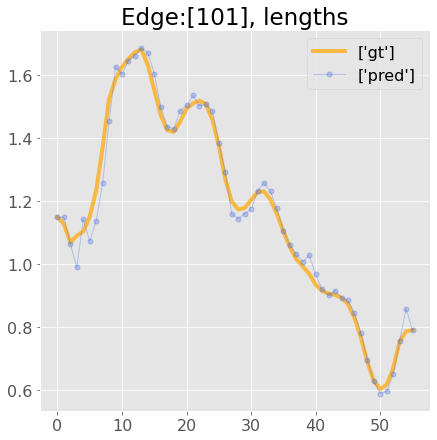

In [21]:
Lij = model_results['val2']['sim005']['targets']['edge_lengths']
Lij_p = model_results['val2']['sim005']['predictions']['edge_lengths']

k=[101]
plt.figure(figsize=[7,7])
plt.plot(Lij[:,k], '-', c='orange', lw=4, alpha=.7,label=['gt']+[None for ki in k[1:]])
plt.plot(Lij_p[:,k], '-o',c='royalblue', lw=1, ms=5, alpha=.3, label=['pred']+[None for ki in k[1:]]);
plt.title(f'Edge:{k}, lengths')
plt.legend();

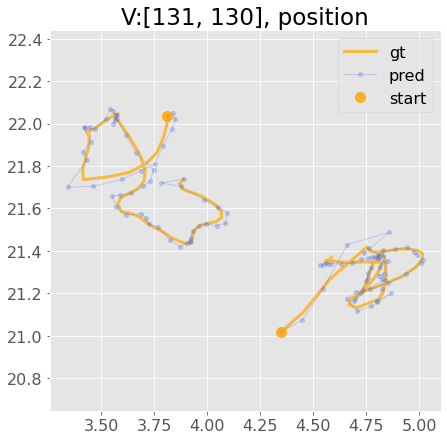

In [56]:
pos = model_results['val2']['sim005']['targets']['pos']
pos_p = model_results['val2']['sim005']['predictions']['pos']

e_st = model_results['val2']['sim005']['edge_index'][:,k]
e_st_list = e_st.ravel().tolist()
plt.figure(figsize=[7,7])
plt.plot(pos[:,e_st_list,0],pos[:,e_st_list,1], '-', c='orange', lw=3, alpha=.7,label=['gt']+[None for k in range(len(e_st_list)-1)])
plt.plot(pos_p[:,e_st_list,0],pos_p[:,e_st_list,1], 'o-',c='royalblue', ms=4, lw=1, alpha=.25, label=['pred']+[None for k in range(len(e_st_list)-1)]);

plt.plot(pos[0,e_st_list,0],pos[0,e_st_list,1], 'o', c='orange', ms=10, alpha=.8,label='start')
# for e_k in range(e_st.shape[1]):
#     plt.plot(pos[-1,e_st[:,e_k],0],pos[-1,e_st[:,e_k],1], '-', c='orange', lw=4, alpha=.5)
#     plt.plot(pos_p[-1,e_st[:,e_k],0],pos_p[-1,e_st[:,e_k],1], '-',c='navy', lw=4, alpha=.4);
plt.title(f'V:{e_st_list}, position')
plt.axis('equal')
plt.legend();

### Predicted Dynamics

In [57]:
# ['train', 'val', 'val2']['movie_1',...,'movie_N']['predictions', 'targets', 'edge_index']

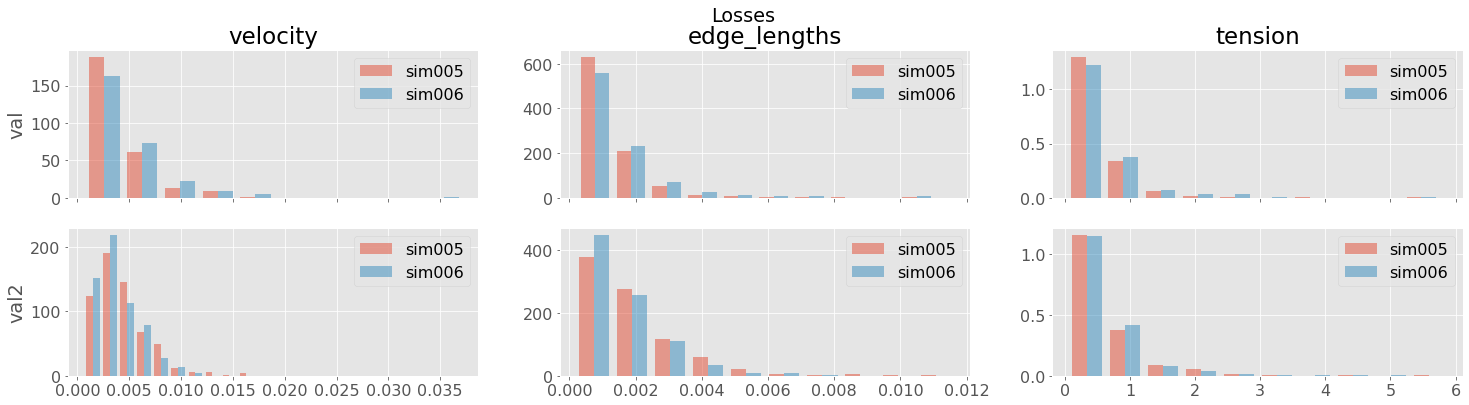

In [22]:
dataset_names = ['val', 'val2'] # list(model_results.keys())

fig, axs = plt.subplots(nrows=len(dataset_names), ncols=3, figsize=[25,1+2.5*len(dataset_names)], sharex='col')

dataset_var_minmax = {}

for dataset_k, ax_k in zip(dataset_names, axs): #zip(, axs):
    dataset_var_minmax[dataset_k] = {}
    for k, var_k in enumerate(['velocity', 'edge_lengths', 'tension']):
        dataset_var_minmax[dataset_k][var_k] = np.array([[np.quantile(model_results[dataset_k][mov_k]['targets'][var_k], 0.01),
                                                          np.quantile(model_results[dataset_k][mov_k]['targets'][var_k], 0.995)]
                                                         for mov_k in model_results[dataset_k]])
        dataset_var_minmax[dataset_k][var_k] = [dataset_var_minmax[dataset_k][var_k][:,0].min(), dataset_var_minmax[dataset_k][var_k][:,1].max()]

        ax_k[k].hist([model_results[dataset_k][mov_k]['loss'][var_k] for mov_k in model_results[dataset_k]],
                     label=[mov_k for mov_k in model_results[dataset_k]], alpha=.5, density=True, stacked=False)
        ax_k[k].legend()
        if dataset_k==dataset_names[0]:
            ax_k[k].set_title(f'{var_k}')
    ax_k[0].set_ylabel(f'{dataset_k}')
plt.suptitle('Losses')
plt.show()

var_limits = {k:np.array([dataset_var_minmax[k_up][k] for k_up in dataset_var_minmax]) for k in ['velocity', 'edge_lengths', 'tension']}
var_limits = {var_k:[var_limits[var_k][:,0].min(), var_limits[var_k][:,1].max()] for var_k in var_limits}

In [23]:
tension_errors_model = {dataname_k:{} for dataname_k in ['val', 'val2']}
for dataname_k in ['val', 'val2']:
    print(dataname_k, ':')
    for mov_k in model_results[dataname_k]:
        tension_errors_model[dataname_k][mov_k] = (model_results[dataname_k][mov_k]['loss']['tension']<.5).nonzero()[0]
        print('  ',mov_k, ':', tension_errors_model[dataname_k][mov_k])

val :
   sim005 : [  0   4   5   6   7   8  10  11  12  13  14  17  18  20  21  24  26  27
  33  34  36  37  38  40  41  42  43  44  46  47  48  49  50  51  53  54
  55  56  58  59  62  63  67  70  73  74  75  77  78  79  81  83  86  87
  89  93  94  95  96  97  98  99 101 102 103 106 107 108 109 110 111 112
 113 114 115 118 119 123 126 127 130 132 133 135 140 141 142 143 144 145
 147 148 150 151 152 153 156 157 158 160 161 164 165 166 167 169 171 172
 173 174 175 176 177 178 179 180 181 182 187 189 192 193 194 196 199 200
 201 204 207 209 210 211 213 215 216 217 219 220 221 222 225 226 229 230
 232 233 234 236 238 240 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 259 260 261 264 265 266 267 270 271 273 274 275 277 278
 279 280 281 282 283 285 286 287 290 291 292 293 294 297 298 300 302 305
 307 308 310 311 312 314 317 318 319 321 323 324 326 328 329 330 331 332
 333 334 335 337 338]
   sim006 : [  3   7   9  10  11  12  13  14  15  16  18  20  21  24  28  29  30  35

In [60]:
# tension_errors = {'val': {'sim005': [19, 65, 91, 121, 214, 237, 325],
#                           'sim006': [17, 25, 99, 115, 137, 145, 215, 256]},
#                   'val2':{'sim005': [53, 73, 87, 92, 97, 105, 133, 139, 196, 199, 261, 280, 344, 352, 371, 404, 419, 425],
#                           'sim006': [21, 55, 67, 89, 159, 190, 207, 221, 242, 289, 295, 343, 370, 380, 384, 445, 483]}
#                  }

In [25]:
tension_errors = tension_errors_model

In [29]:
np.random.seed(0)
for dataname_k in tension_errors:
    for mov_k in tension_errors[dataname_k]:
        print('-'*10+'\n',f'{dataname_k}:{mov_k}\n')
        N_plots = min([3*(len(tension_errors[dataname_k][mov_k])//3), 15])
        
        e_ids = np.sort(np.random.choice(tension_errors[dataname_k][mov_k], size=(N_plots,), replace=False))
        
        fig, axs = plt.subplots(nrows=N_plots//3, ncols=3, figsize=[20, 6*(N_plots//3)+1], gridspec_kw={'wspace':.5, 'hspace':.5})

        for k, ax in zip(e_ids, axs.ravel()):
            # Edge tensions
            Te_tgt = model_results[dataname_k][mov_k]['targets']['tension'][:,k]
            Te_pred = model_results[dataname_k][mov_k]['predictions']['tension'][:,k]
            Te_loss = model_results[dataname_k][mov_k]['loss']['tension'][k] # Tension pred-n loss
            # Edge lengths
            Le_tgt = model_results[dataname_k][mov_k]['targets']['edge_lengths'][:,k]
            Le_pred = model_results[dataname_k][mov_k]['predictions']['edge_lengths'][:,k]
            
            p1, = ax.plot(Te_tgt, '--', c='royalblue', alpha=0.7, lw=3, label=r'$T_{tgt}$')
            ax.plot(Te_pred, c='teal', alpha=0.4, lw=3, label=r'$T_{pred}$')
            
            ax2 = ax.twinx()
            p2, = ax2.plot(Le_tgt, c='crimson', alpha=0.7, lw=3, label=r'$L_{tgt}$')
            ax2.plot(Le_pred, c='darkorange', alpha=0.7, lw=3, label=r'$L_{pred}$')
            
            ax.set_xlabel(f'Frames (edge {k})', fontsize=12)
            ax.set_title(f'MSE_t={Te_loss:.3f}', fontsize=12)
            ax.set_ylabel(r'Tension', color=p1.get_color())
            ax.tick_params(axis='y', labelcolor=p1.get_color())
            ax.set_ylim(var_limits['tension'][0], var_limits['tension'][1])
            
            ax2.set_ylabel(r'Edge Length', color=p2.get_color())
            ax2.tick_params(axis='y', labelcolor=p2.get_color())
            ax2.set_ylim(var_limits['edge_lengths'][0], var_limits['edge_lengths'][1])
            
            ax2.legend(loc='upper right')
            ax.legend(loc='upper left')
        plt.suptitle(f'{dataname_k}:{mov_k}', fontsize=15, y=0.93)
        plt.savefig(f'./{dataname_k}_{mov_k}_tension_dynamics_prediction_LOW_error.png',dpi=100, bbox_inches="tight")
#         plt.show()
        plt.close()

----------
 val:sim005

----------
 val:sim006

----------
 val2:sim005

----------
 val2:sim006

